In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cosima_cookbook as cc
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:43863 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 155.69 GB


In [40]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def southern_ocean(ds):
    ds = ds.sel(yu_ocean = slice(None, -50))
    return ds

def southern_ocean_plot():
    fig = plt.figure(1, figsize = (15, 16))
    ax1 = fig.add_axes([0.0, 0.5, 0.5, 0.5], projection = ccrs.SouthPolarStereo())
    ax1.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'white', facecolor = 'white'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform = ax1.transAxes)
    
    ax2 = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
    ax2.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'white', facecolor = 'white'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax2.set_boundary(circle, transform = ax2.transAxes)
    
    return fig, ax1, ax2

In [39]:
hu = xr.open_dataset('/scratch/e14/jn8053/misc/hu-01deg.nc')['hu']

In [4]:
files_ryf = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easup = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easdo = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_down10//output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]

In [5]:
example = xr.open_dataset(files_ryf[0])
drop = [i for i in example.variables]
drop.remove('tau_x')
drop.remove('tau_y')
drop.remove('xu_ocean')
drop.remove('yu_ocean')
drop.remove('time')

In [6]:
tau_ryf = xr.open_mfdataset(files_ryf, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
tau_up = xr.open_mfdataset(files_easup, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
tau_down = xr.open_mfdataset(files_easdo, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)

In [52]:
tau_ryf['tau_x']

<xarray.DataArray 'tau_x' (time: 180, yu_ocean: 665, xu_ocean: 3600)>
dask.array<concatenate, shape=(180, 665, 3600), dtype=float32, chunksize=(3, 665, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2150-01-16 12:00:00 ... 2164-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -50.19 -50.12 -50.06
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  surface_downward_x_stress

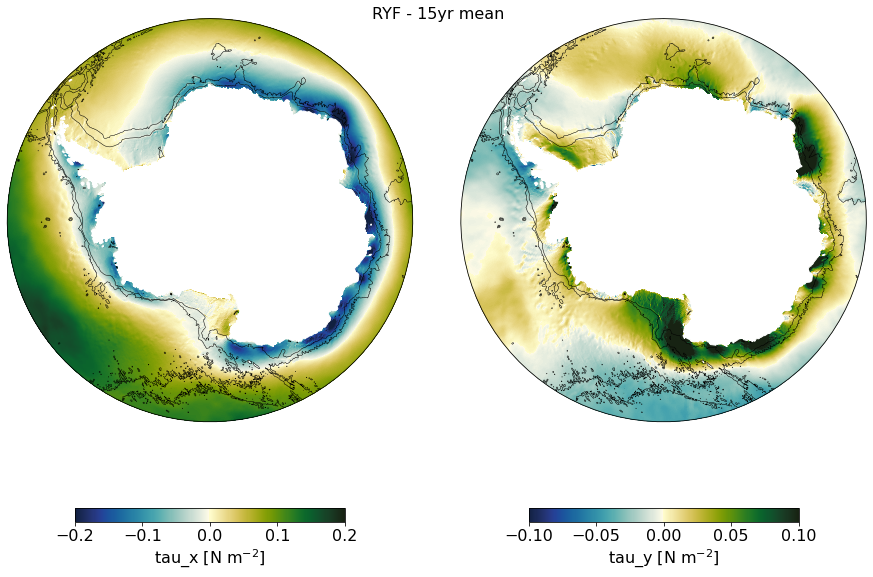

In [42]:
fig, ax1, ax2 = southern_ocean_plot()
fig.text(0.4, 1, 'RYF - 15yr mean', fontsize = 16)
cf = ax1.pcolormesh(tau_ryf['xu_ocean'], tau_ryf['yu_ocean'], tau_ryf['tau_x'].mean('time'), 
                    vmin = -0.2, vmax = 0.2, cmap = cmocean.cm.delta, transform = ccrs.PlateCarree())
ax1.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = ax1, orientation = 'horizonal', shrink = .5)
cbar.set_label('tau_x [N m$^{-2}$]')

cf = ax2.pcolormesh(tau_ryf['xu_ocean'], tau_ryf['yu_ocean'], tau_ryf['tau_y'].mean('time'), 
                    vmin = -0.1, vmax = 0.1, cmap = cmocean.cm.delta, transform = ccrs.PlateCarree())
ax2.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = ax2, orientation = 'horizontal', shrink = .5)
cbar.set_label('tau_y [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy-ryf-mean.png')

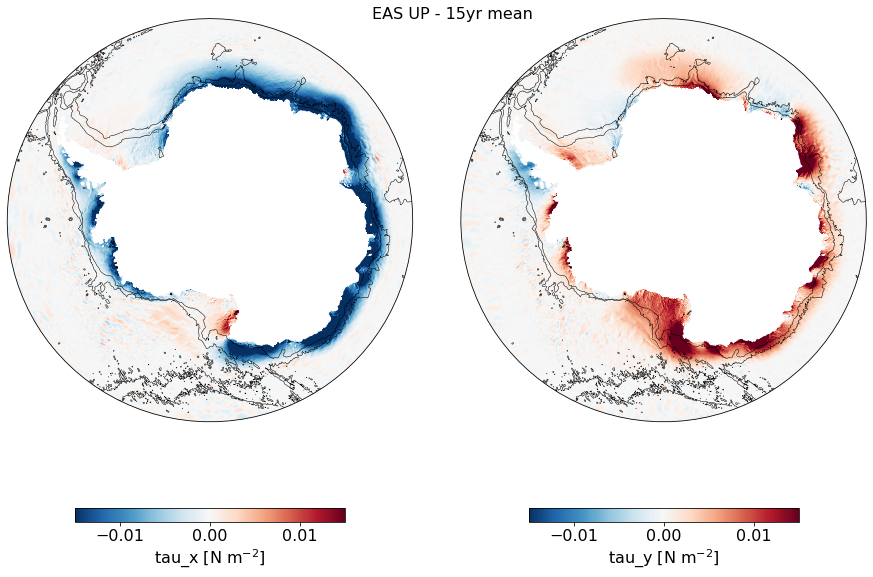

In [43]:
fig, ax1, ax2 = southern_ocean_plot()
fig.text(0.4, 1, 'EAS UP - 15yr mean', fontsize = 16)
cf = ax1.pcolormesh(tau_up['xu_ocean'], tau_up['yu_ocean'], tau_up['tau_x'].mean('time') - tau_ryf['tau_x'].mean('time'), 
                    vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
ax1.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = ax1, orientation = 'horizonal', shrink = .5)
cbar.set_label('tau_x [N m$^{-2}$]')

cf = ax2.pcolormesh(tau_up['xu_ocean'], tau_up['yu_ocean'], tau_up['tau_y'].mean('time') - tau_ryf['tau_y'].mean('time'), 
                    vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
ax2.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = ax2, orientation = 'horizontal', shrink = .5)
cbar.set_label('tau_y [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy-easup-mean.png')

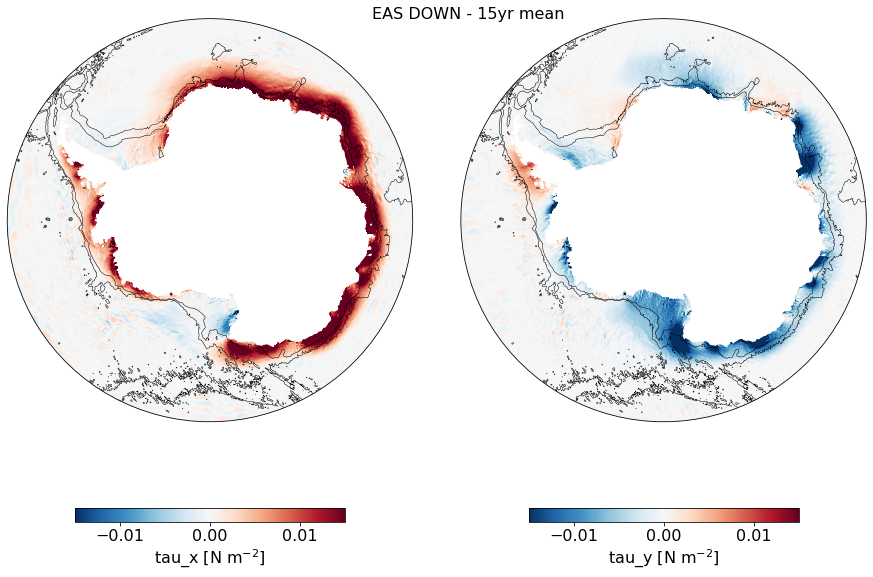

In [44]:
fig, ax1, ax2 = southern_ocean_plot()
fig.text(0.4, 1, 'EAS DOWN - 15yr mean')
cf = ax1.pcolormesh(tau_down['xu_ocean'], tau_down['yu_ocean'], tau_down['tau_x'].mean('time') - tau_ryf['tau_x'].mean('time'), 
                    vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
ax1.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = ax1, orientation = 'horizonal', shrink = .5)
cbar.set_label('tau_x [N m$^{-2}$]')

cf = ax2.pcolormesh(tau_down['xu_ocean'], tau_down['yu_ocean'], tau_down['tau_y'].mean('time') - tau_ryf['tau_y'].mean('time'), 
                    vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
ax2.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax = ax2, orientation = 'horizontal', shrink = .5)
cbar.set_label('tau_y [N m$^{-2}$]')

plt.savefig(figdir+'easterlies-collaborative/tau_xy-easdown-mean.png')

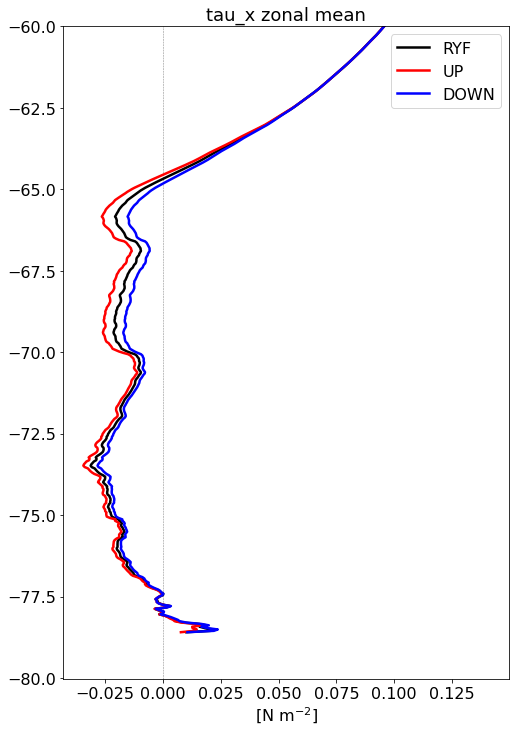

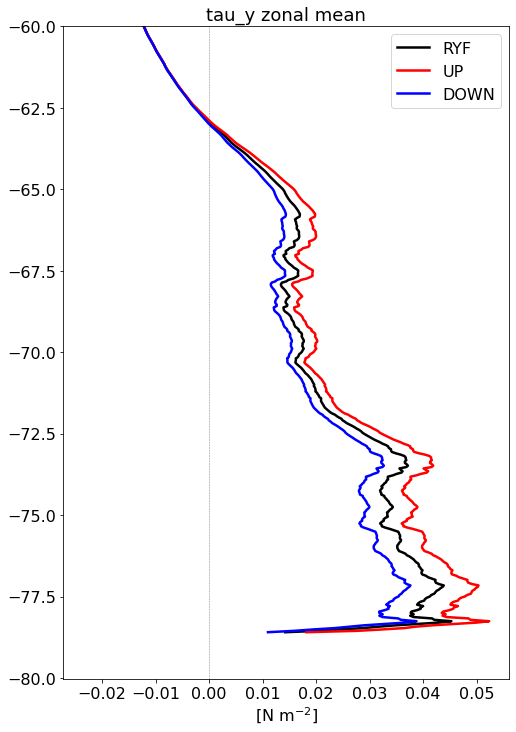

In [38]:
fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.plot(tau_ryf['tau_x'].mean('time').mean('xu_ocean'), tau_ryf['yu_ocean'], color = 'k', linewidth = 2.5, label = 'RYF')
axs.plot(tau_up['tau_x'].mean('time').mean('xu_ocean'), tau_up['yu_ocean'], color = 'r', linewidth = 2.5, label = 'UP')
axs.plot(tau_down['tau_x'].mean('time').mean('xu_ocean'), tau_down['yu_ocean'], color = 'b', linewidth = 2.5, label = 'DOWN')
axs.set_ylim(None, -60)
axs.set_xlabel('[N m$^{-2}$]')
plt.legend()
plt.title('tau_x zonal mean', fontsize = 18)
plt.savefig(figdir+'/easterlies-collaborative/tau_x_zonal_mean.png')

fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.plot(tau_ryf['tau_y'].mean('time').mean('xu_ocean'), tau_ryf['yu_ocean'], color = 'k', linewidth = 2.5, label = 'RYF')
axs.plot(tau_up['tau_y'].mean('time').mean('xu_ocean'), tau_up['yu_ocean'], color = 'r', linewidth = 2.5, label = 'UP')
axs.plot(tau_down['tau_y'].mean('time').mean('xu_ocean'), tau_down['yu_ocean'], color = 'b', linewidth = 2.5, label = 'DOWN')
plt.title('tau_y zonal mean', fontsize = 18)
axs.set_ylim(None, -60)
axs.set_xlabel('[N m$^{-2}$]')
plt.legend()
plt.savefig(figdir+'/easterlies-collaborative/tau_y_zonal_mean.png')